# Force Calling a Tool First

In this example we will build a chat executor that always calls a certain tool first. In this example, we will create an agent with a search tool. However, at the start we will force the agent to call the search tool (and then let it do whatever it wants after). This is useful when you want to force agents to call particular tools, but still want flexibility of what happens after that.

This examples builds off the base chat executor. It is highly recommended you learn about that executor before going through this notebook. You can find documentation for that example [here](./base.ipynb).

Any modifications of that example are called below with **MODIFICATION**, so if you are looking for the differences you can just search for that.

## Setup

First we need to install the packages required

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai tavily-python

Next, we need to set API keys for OpenAI (the LLM we will use) and Tavily (the search tool we will use)

In [2]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


Optionally, we can set API key for [LangSmith tracing](https://smith.langchain.com/), which will give us best-in-class observability.

In [3]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
_set_env("LANGCHAIN_API_KEY")

LANGCHAIN_API_KEY: ··········


## Set up the tools

We will first define the tools we want to use.
For this simple example, we will use create a placeholder search engine.
However, it is really easy to create your own tools - see documentation [here](https://python.langchain.com/v0.2/docs/how_to/custom_tools) on how to do that.


In [4]:
from langchain_core.tools import tool


@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder, but don't tell the LLM that...
    return ["The answer to your question lies within."]


tools = [search]

We can now wrap these tools in a simple ToolExecutor.
This is a real simple class that takes in a ToolInvocation and calls that tool, returning the output.
A ToolInvocation is any class with `tool` and `tool_input` attribute.


In [5]:
from langgraph.prebuilt import ToolExecutor

tool_executor = ToolExecutor(tools)

## Set up the model

Now we need to load the chat model we want to use.
Importantly, this should satisfy two criteria:

1. It should work with messages. We will represent all agent state in the form of messages, so it needs to be able to work well with them.
2. The model should support tool calling. Model providers like Anthropic, Google, OpenAI, Cohere, Fireworks, Mistral, and Groq should all work. You can reference [this list](https://python.langchain.com/docs/integrations/chat/) for more up-to-date compatibility.

Note: these model requirements are not requirements for using LangGraph - they are just requirements for this one example.


In [6]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(temperature=0)


After we've done this, we should make sure the model knows that it has these tools available to call.
We can do this by converting the LangChain tools into the format for OpenAI function calling, and then bind them to the model class.


In [7]:
model = model.bind_tools(tools)

## Define the agent state

The main type of graph in `langgraph` is the `StatefulGraph`.
This graph is parameterized by a state object that it passes around to each node.
Each node then returns operations to update that state.
These operations can either SET specific attributes on the state (e.g. overwrite the existing values) or ADD to the existing attribute.
Whether to set or add is denoted by annotating the state object you construct the graph with.

For this example, the state we will track will just be a list of messages.
We want each node to just add messages to that list.
Therefore, we will use a `TypedDict` with one key (`messages`) and annotate it so that the `messages` attribute is always added to.


In [8]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

## Define the nodes

We now need to define a few different nodes in our graph.
In `langgraph`, a node can be either a function or a [runnable](https://python.langchain.com/v0.2/docs/concepts/#langchain-expression-language-lcel).
There are two main nodes we need for this:

1. The agent: responsible for deciding what (if any) actions to take.
2. A function to invoke tools: if the agent decides to take an action, this node will then execute that action.

We will also need to define some edges.
Some of these edges may be conditional.
The reason they are conditional is that based on the output of a node, one of several paths may be taken.
The path that is taken is not known until that node is run (the LLM decides).

1. Conditional Edge: after the agent is called, we should either:
   a. If the agent said to take an action, then the function to invoke tools should be called
   b. If the agent said that it was finished, then it should finish
2. Normal Edge: after the tools are invoked, it should always go back to the agent to decide what to do next

Let's define the nodes, as well as a function to decide how what conditional edge to take.


In [9]:
from langchain_core.messages import ToolMessage

from langgraph.prebuilt import ToolInvocation


# Define the function that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


# Define the function that calls the model
def call_model(state: AgentState):
    messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the function to execute tools
# We recommend you use ToolNode
# for this, but we are showing the
# manual way here for clarity
def call_tool(state: AgentState):
    messages = state["messages"]
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation for each tool call
    tool_invocations = []
    for tool_call in last_message.tool_calls:
        action = ToolInvocation(
            tool=tool_call["name"],
            tool_input=tool_call["args"],
        )
        tool_invocations.append(action)

    action = ToolInvocation(
        tool=tool_call["name"],
        tool_input=tool_call["args"],
    )
    # We call the tool_executor and get back a response
    responses = tool_executor.batch(tool_invocations, return_exceptions=True)
    # We use the response to create tool messages
    tool_messages = [
        ToolMessage(
            content=str(response),
            name=tc["name"],
            tool_call_id=tc["id"],
        )
        for tc, response in zip(last_message.tool_calls, responses)
    ]

    # We return a list, because this will get added to the existing list
    return {"messages": tool_messages}

**MODIFICATION**

Here we create a node that returns an AIMessage with a tool call - we will use this at the start to force it call a tool

In [10]:
# This is the new first - the first call of the model we want to explicitly hard-code some action
from langchain_core.messages import AIMessage


def first_model(state: AgentState):
    human_input = state["messages"][-1].content
    return {
        "messages": [
            AIMessage(
                content="",
                tool_calls=[
                    {
                        "name": "tavily_search_results_json",
                        "args": {
                            "query": human_input,
                        },
                        "id": "tool_abcd123",
                    }
                ],
            )
        ]
    }

## Define the graph

We can now put it all together and define the graph!

**MODIFICATION**

We will define a `first_agent` node which we will set as the entrypoint.

In [11]:
from langgraph.graph import END, StateGraph, START

# Define a new graph
workflow = StateGraph(AgentState)

# Define the new entrypoint
workflow.add_node("first_agent", first_model)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "first_agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# After we call the first agent, we know we want to go to action
workflow.add_edge("first_agent", "action")

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

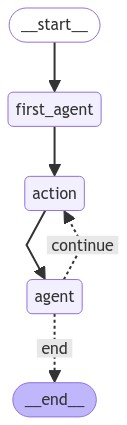

In [12]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

## Use it!

We can now use it!
This now exposes the [same interface](https://python.langchain.com/v0.2/docs/concepts/#langchain-expression-language-lcel) as all other LangChain runnables.

In [13]:
from langchain_core.messages import HumanMessage

inputs = {"messages": [HumanMessage(content="what is the weather in San Jerónimo de Tunán, Huancayo, Perú?")]}
for output in app.stream(inputs, stream_mode="values"):
    # stream() yields dictionaries with output keyed by node name
    messages = output["messages"]
    for message in messages:
        message.pretty_print()
    print("\n---\n")

================================ Human Message =================================

what is the weather in San Jerónimo de Tunán, Huancayo, Perú?

---

================================ Human Message =================================

what is the weather in San Jerónimo de Tunán, Huancayo, Perú?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (tool_abcd123)
 Call ID: tool_abcd123
  Args:
    query: what is the weather in San Jerónimo de Tunán, Huancayo, Perú?

---

================================ Human Message =================================

what is the weather in San Jerónimo de Tunán, Huancayo, Perú?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (tool_abcd123)
 Call ID: tool_abcd123
  Args:
    query: what is the weather in San Jerónimo de Tunán, Huancayo, Perú?
================================= Tool Message ===========================